# Bayesian Estimation of Prospect Theory Parameters
This notebook builds a PyMC model to estimate parameters of a decision-making model using behavioral data.

In [1]:
import pymc as pm
import numpy as np
import pandas as pd
# import aesara.tensor as at
import arviz as az
import pickle

In [3]:
fname = 'results_raw.pickle'
# Create a writer object
file = open(fname, 'rb')

# dump information
results_decision = pickle.load(file)

data = pd.concat(results_decision, names=['subject'])


## Load Data

In [4]:
# Load your dataset here
# It should have columns: invest, potential_gain, potential_loss, probability_win_percent, probability_loss_percent

# Example (you should replace this with real data loading)
# data = pd.read_csv("your_data.csv")
data.head()


trial_num  response_time  invest  prob_win  prob_loss  prob_ambi  \
subject                                                                       
11112   0          1      13.293310     1.0       0.2        0.3        0.5   
        1          2       5.902034     0.0       0.2        0.0        0.8   
        2          3       7.698850     1.0       0.4        0.3        0.3   
        3          4      10.992664     0.0       0.5        0.0        0.5   
        4          5       7.219638     1.0       0.0        0.2        0.8   

              gain    loss  lottery_trial_num  group_responsibility  
subject                                                              
11112   0   7000.0 -3000.0               29.0                   0.0  
        1  10000.0 -6000.0               46.0                   0.0  
        2   4000.0 -2000.0               19.0                   0.0  
        3   3000.0 -7000.0                3.0                   0.0  
        4   5000.0 -1000.0               43.0                   0.0

## Define Utility Functions

In [17]:
def calc_eta(green, red, theta):
    return green + (1 - green - red) * theta

def calc_subj_prob(p, gamma):
    return (p ** gamma) / ((p ** gamma + (1 - p) ** gamma) ** (1 / gamma))


def calc_subj_values(x, Lambda, alpha, beta):
    """Calculates the subjective value of gains and losses, given an alpha parameter. Lambda estimate.
    Alpha could be estimated but used as constant=0.9."""
    return pm.math.switch(
        x >= 0,
        x ** alpha,
        -Lambda * ((-x) ** beta)
    )

def pt_utility(gain, loss, p_win, p_loss, theta, Lambda, alpha, beta, gamma):
    eta_gain = calc_eta(p_win, p_loss, theta).clip(0,1)
    eta_loss = calc_eta(p_loss, p_win, 1 - theta).clip(0,1)
    v_gain = calc_subj_values(gain, Lambda, alpha, beta)
    v_loss = calc_subj_values(-loss, Lambda, alpha, beta)
    pi_gain = calc_subj_prob(eta_gain, gamma)
    pi_loss = calc_subj_prob(eta_loss, gamma)
    return v_gain * pi_gain + v_loss * pi_loss


## Build and Sample the Bayesian Model

In [34]:
with pm.Model() as model:
    # Priors
    theta = pm.Lognormal('theta', mu=0, sigma=1)
    Lambda = pm.Lognormal('Lambda', mu=0, sigma=1)
    tau = 0.4#pm.Lognormal('tau', mu=0, sigma=1)
    alpha = 0.9#pm.Lognormal('alpha', mu=0, sigma=1)
    beta = 0.9#pm.Lognormal('beta', mu=0, sigma=1)
    gamma = pm.Lognormal('gamma', mu=0, sigma=1)
    error = pm.Normal('error', mu=0, sigma=1)

    # Data
    gain = pm.Data('gain', data['gain'])
    loss = pm.Data('loss', data['loss'])
    p_win = pm.Data('p_win', data['prob_win'])
    p_loss = pm.Data('p_loss', data['prob_loss'])
    invest = pm.Data('invest', data['invest'])

    # Model logic
    utility = pt_utility(gain, loss, p_win, p_loss, theta, Lambda, alpha, beta, gamma)
    # prob = pm.Deterministic('prob', 1 / (1 + np.exp(-tau * (utility - error))))
    prob = pm.Deterministic('prob', pm.math.sigmoid(tau * (utility - error)))

    # Likelihood
    y_obs = pm.Bernoulli('y_obs', p=prob, observed=invest)

    # Sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, Lambda, gamma, error]


/Users/administrator/miniforge3/envs/mgme_task/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 5 seconds.
There were 8000 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
pm.model_to_graphviz(model)


/Users/administrator/miniforge3/envs/mgme_task/lib/python3.10/site-packages/arviz/stats/diagnostics.py:509: RuntimeWarning: invalid value encountered in divide
  return num / den


<Axes: >

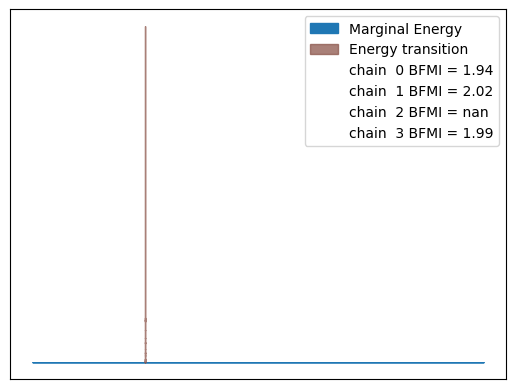

In [30]:
az.plot_energy(trace)

array([<Axes: title={'center': '95.0% HDI'}>,
       <Axes: title={'center': 'r_hat'}>], dtype=object)

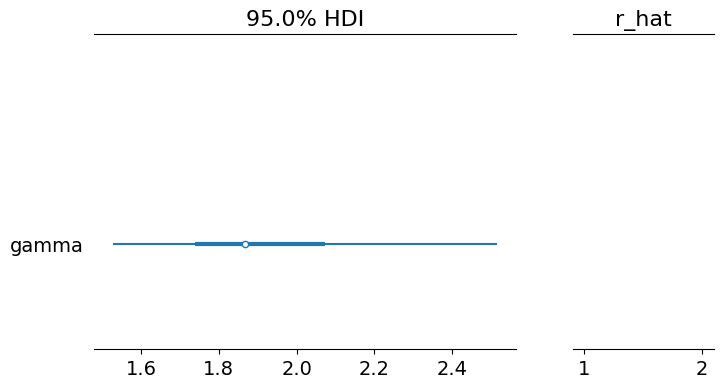

In [31]:
az.plot_forest(trace, var_names=["gamma"], combined=True, hdi_prob=0.95, r_hat=True)


## Posterior Analysis

/Users/administrator/miniforge3/envs/mgme_task/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/administrator/miniforge3/envs/mgme_task/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/administrator/miniforge3/envs/mgme_task/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/administrator/miniforge3/envs/mgme_task/lib/python3.10/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your da

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
error,0.56,0.42,0.06,1.00,0.21,0.03,4.02,4.02,5.877474e+15
theta,1.48,0.50,0.98,1.99,0.25,0.00,4.02,4.02,5.341631e+15
Lambda,1.23,0.24,0.98,1.62,0.12,0.06,4.02,4.02,5.341631e+15
tau,1.67,0.76,0.80,2.73,0.38,0.13,4.02,4.02,5.877474e+15
alpha,2.36,1.25,1.00,4.25,0.62,0.26,4.02,4.02,5.341631e+15
...,...,...,...,...,...,...,...,...,...
prob[2770],1.00,0.00,1.00,1.00,0.00,NaN,8000.00,8000.00,NaN
prob[2771],1.00,0.00,1.00,1.00,0.00,NaN,8000.00,8000.00,NaN
prob[2772],1.00,0.00,1.00,1.00,0.00,NaN,8000.00,8000.00,NaN
prob[2773],1.00,0.00,1.00,1.00,0.00,NaN,8000.00,8000.00,NaN


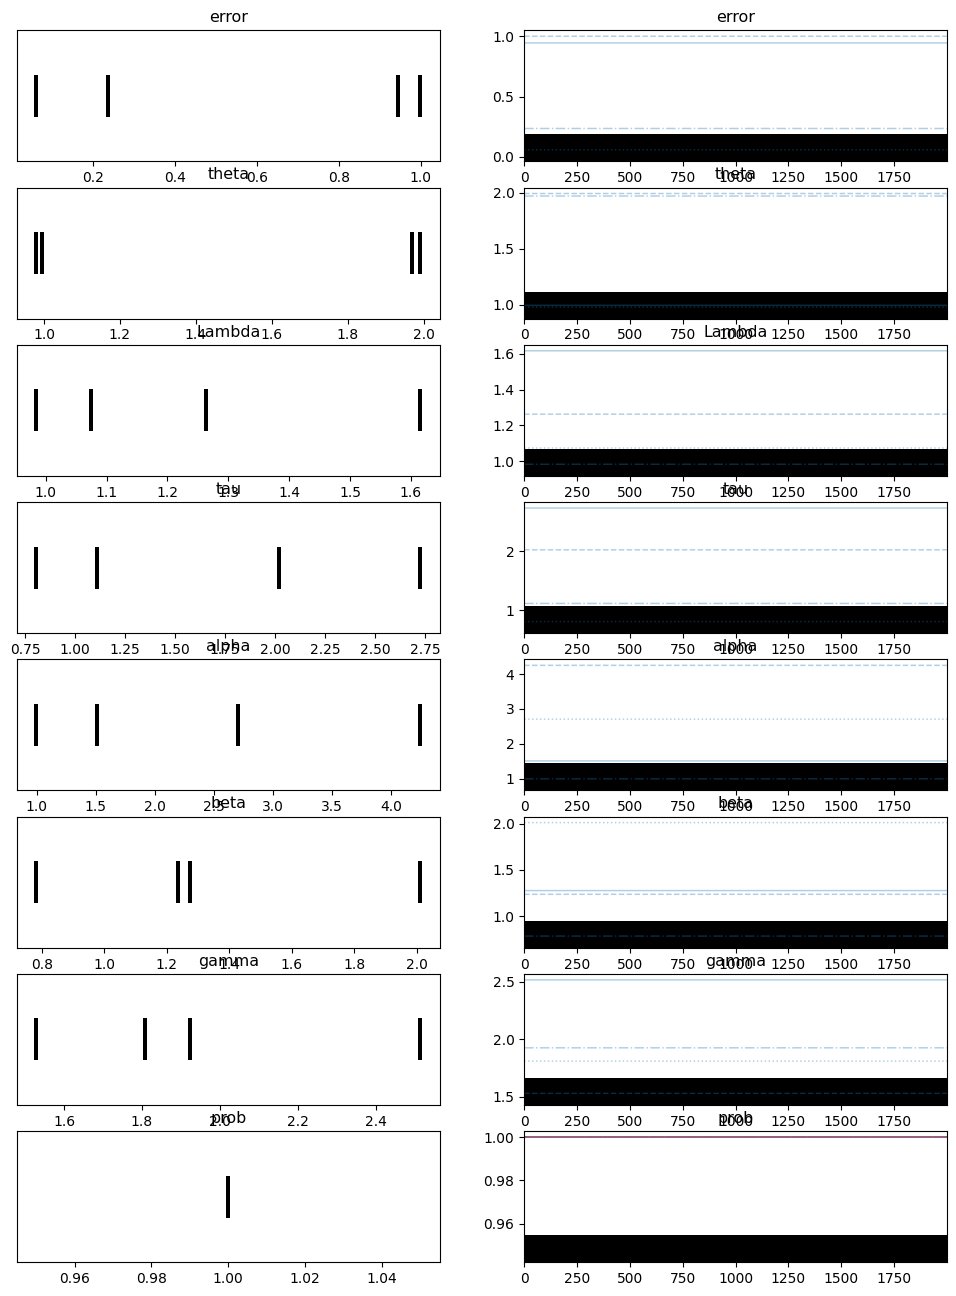

In [ ]:
High R-hat values indicate poor convergence, often due to model complexity, identifiability issues, or insufficient tuning. Here are some suggestions:

1. **Simplify the model:**  
    - Fix some parameters (e.g., set `alpha` and `beta` to constants if theory allows).
    - Remove or combine parameters that may be redundant.

2. **Reparameterize:**  
    - Use more informative priors.
    - Check for strong correlations between parameters.

3. **Increase tuning:**  
    - Increase the `tune` parameter in `pm.sample()` (e.g., `tune=2000`).

4. **Check data:**  
    - Ensure data quality and that all columns are as expected.

5. **Run diagnostics:**  
    - Use `az.plot_trace(trace)` and `az.plot_pair(trace)` to inspect sampling.

Try simplifying the model first (e.g., fix `alpha=0.9`, `beta=0.9`) and see if convergence improves.
